In [1]:
import os
import pickle
import sys
import h5py
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from tqdm import tnrange, tqdm_notebook

# os.chdir('codes')
import models
import sklearn.metrics as metrics
from PIL import Image

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

prepare data

In [2]:
with h5py.File(os.path.join('./', 'npc_v4_data.h5')) as hf:
    print(hf.keys())
    print('Datasets:', [d for d in hf.values() if isinstance(d, h5py.Dataset)])

KeysView(<HDF5 file "npc_v4_data.h5" (mode r+)>)
Datasets: [<HDF5 dataset "readme": shape (), type "|O">]


In [3]:
# CHOOSE THE AUGMENTS IF NECESSARY
device = 'cuda:0' # device where you put your data and models
data_path = './' # the path of the 'npc_v4_data.h5' file
batch_size = 50 # the batch size of the data loader
insp_layer = 'conv3' # the middle layer extracted from alexnet, available in {'conv1', 'conv2', 'conv3', 'conv4', 'conv5'}

"""
The file npc_v4_data.h5 is structured in the following way:
images: a tensor of shape [num_images, width, height, num_colors]
neural data: a tensor of shape [num_repetitions, num_images, num_neurons]
target indices: a list containing the indices of target neurons in data tensor
For some animals the data is collected within two sessions that are indicated by session_x
"""

with h5py.File(os.path.join(data_path, 'npc_v4_data.h5')) as hf:
    print(hf.keys())
    images_n = np.array(hf['images']['naturalistic'])
    neural_n = np.array(hf['neural']['naturalistic']['monkey_m']['stretch']['session_2'])

print(neural_n.shape)
n_images = neural_n.shape[1]
n_neurons = neural_n.shape[2]
size_imags = images_n.shape[0]

img = np.zeros((images_n.shape[0], images_n[0].shape[0], images_n[0].shape[1], 3), dtype=np.uint8)
for i in range(640):
    rgb_img = np.zeros((images_n[i].shape[0], images_n[i].shape[1], 3), dtype=np.uint8)
    rgb_img[:, :, 0] = images_n[i]
    rgb_img[:, :, 1] = images_n[i]
    rgb_img[:, :, 2] = images_n[i]
    img[i] = rgb_img


print('img: ', img.shape)
# for data in images_n:
#     plt.imshow(data)
print(images_n.shape)
print(neural_n.shape)
print(n_images, n_neurons, size_imags)

reps = neural_n.shape[0]
rand_ind = np.arange(reps)
np.random.shuffle(rand_ind)


data_y_train = neural_n[:,:576].mean(0).astype(np.float32)
data_y_val_origin = neural_n[:, 576:].astype(np.float32)
data_y_val = data_y_val_origin.mean(0)

#data_x = images_n[:, np.newaxis].astype(np.float32)
data_x = img
print('images_n', images_n.shape)
print(data_x.shape)

data_x = data_x / 255 # (640, 1, 299, 299)

print(type(data_x))

print(data_x.shape)
#data_x = np.tile(data_x, [1, 3, 1, 1])
data_x = np.transpose(data_x, (0, 3, 1, 2))
print('data_x', data_x.shape)
data_x_train = data_x[:576]
data_x_val = data_x[576:]


class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
    def __getitem__(self, index):
        return self.data_x[index], self.data_y[index]
    def __len__(self):
        return self.data_x.shape[0]

imagenet_mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).view(1, 3, 1, 1).to(device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).view(1, 3, 1, 1).to(device)
transform = lambda x : (x - imagenet_mean) / imagenet_std

dataset_train = Dataset(data_x_train, data_y_train)
dataset_val = Dataset(data_x_val, data_y_val)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

KeysView(<HDF5 file "npc_v4_data.h5" (mode r+)>)
(36, 640, 52)
img:  (640, 299, 299, 3)
(640, 299, 299)
(36, 640, 52)
640 52 640
images_n (640, 299, 299)
(640, 299, 299, 3)
<class 'numpy.ndarray'>
(640, 299, 299, 3)
data_x (640, 3, 299, 299)


# Problem (a)

In [4]:
()

()

In [5]:
# CHOOSE THE AUGMENTS IF NECESSARY
lamd_s, lamd_d = [1e-1, 1e-1] # the coefficients of the losses. Try other coefficients!
epoches = 100 # total epochs for training the encoder
lr = 1e-1 # the learing rate for training the encoder

alexnet = models.alexnet(pretrained=True)
alexnet.to(device)
alexnet.eval()
for param in alexnet.parameters():
    param.requires_grad_(False)

x = torch.from_numpy(data_x[0:1]).float().to(device)
print("x:", x.shape)
fmap = alexnet(x, layer=insp_layer)

neurons = data_y_train.shape[1]
sizes = fmap.shape[2:]
print("fmap: ", fmap.shape)
print("size: ", sizes)
channels = fmap.shape[1]
print(neurons, sizes)
w_s = nn.Parameter(torch.randn(size=(neurons,) + sizes))
print(w_s.shape)

x: torch.Size([1, 3, 299, 299])
fmap:  torch.Size([1, 384, 17, 17])
size:  torch.Size([17, 17])
52 torch.Size([17, 17])
torch.Size([52, 17, 17])


In [6]:
class conv_encoder(nn.Module):

    def __init__(self, neurons, sizes, channels):
        super(conv_encoder, self).__init__()
        # PUT YOUR CODES HERE
        self.W_s = nn.Parameter(torch.randn(size=(neurons,) + sizes))
        self.W_d = nn.Parameter(torch.randn(size = (neurons,channels,1,1)))
        self.W_b = nn.Parameter(torch.randn(size = (1,neurons)))


    def forward(self, x):
        # PUT YOUR CODES HERE
        out = torch.einsum('bchw , nhw -> bnchw',x,self.W_s) # dimension : N,n,C,h,w
        out = torch.stack(
            [F.conv2d(out[:,n,:,:,:],torch.unsqueeze(self.W_d[n],0)) for n in range(neurons)],dim=1) 
            #dimension:N,n,1,h,w
        out = torch.sum(out,dim=(2,3,4))
        out = out + self.W_b
        return out

def L_e(y,pred):
    return torch.mean(torch.sqrt(torch.sum((y-pred)**2,dim=1)))

def L_2(W_s,W_d,lamd_s=lamd_s,lamd_d=lamd_d):
    return lamd_s * torch.sum(W_s**2) + lamd_d * torch.sum(W_d**2)

K = torch.tensor([
    [0,-1,0],
    [-1,4,-1],
    [0,-1,0]],dtype=torch.float).to(device)
def L_laplace(W_s,lamd_s=lamd_s):
    return lamd_s * torch.sum(F.conv2d(torch.unsqueeze(W_s,1),K.unsqueeze(0).unsqueeze(0))**2)


#encoder = conv_encoder(neurons, sizes, channels).to(device)
encoder = conv_encoder(neurons, sizes, channels).to(device)

In [7]:
def train_model(encoder, optimizer):
    losses = []
    encoder.train()
    for i,(x,y) in enumerate(loader_train):
        optimizer.zero_grad()
        x = x.float().to(device)
        y = y.float().to(device)
        x = transform(x)
        fmap = alexnet(x,layer = insp_layer)
        out = encoder(fmap)
        l_e = L_e(y,out)
        l_2 = L_2(encoder.W_s,encoder.W_d)
        l_l = L_laplace(encoder.W_s)
#         print(f'L_e = {l_e} , L_2 = {l_2} , L_l = {l_l}')
        loss = L_e(y,out) + L_2(encoder.W_s,encoder.W_d) + L_laplace(encoder.W_s)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
#         print(f'iteration {i}, train loss: {losses[-1]}')
    
    return losses

def validate_model(encoder):
    encoder.eval()
    y_pred = []
    y_true = []
    losses = []
    for i,(x,y) in enumerate(loader_val):
        x = x.float().to(device)
        y = y.float().to(device)
        x = transform(x)
        fmap = alexnet(x,layer = insp_layer)
        out = encoder(fmap)
        y_pred.append(out)
        y_true.append(y)
        l_e = L_e(y,out)
        l_2 = L_2(encoder.W_s,encoder.W_d)
        l_l = L_laplace(encoder.W_s)
        print(f'L_e = {l_e} , L_2 = {l_2} , L_l = {l_l}')
        loss = L_e(y,out) + L_2(encoder.W_s,encoder.W_d) + L_laplace(encoder.W_s)
        losses.append(loss.item())
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
    explained_variance = metrics.explained_variance_score(y_true = y_true.detach().cpu().numpy(),y_pred = y_pred.detach().cpu().numpy())
    return explained_variance,sum(losses)/len(losses)

"""
    You need to define the conv_encoder() class and train the encoder.
    The code of alexnet has been slightly modified from the torchvision, for convenience
    of extracting the middle layers.
    
    Example:
        >>> x = x.to(device) # x is a batch of images
        >>> x = transform(x)
        >>> fmap = alexnet(x, layer=insp_layer)
        >>> out= encoder(fmap)
        >>> ...
"""

'\n    You need to define the conv_encoder() class and train the encoder.\n    The code of alexnet has been slightly modified from the torchvision, for convenience\n    of extracting the middle layers.\n    \n    Example:\n        >>> x = x.to(device) # x is a batch of images\n        >>> x = transform(x)\n        >>> fmap = alexnet(x, layer=insp_layer)\n        >>> out= encoder(fmap)\n        >>> ...\n'

In [8]:
# losses_train = []
# losses_val = []
# EVs = []

losses_train = []
losses_val = []
EVs = []

In [9]:

lr = 1e-1
optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

In [10]:

for epoch in tqdm_notebook(range(epoches)):
    losses_train += train_model(encoder,optimizer)
    ev,loss = validate_model(encoder)
    EVs.append(ev)
    losses_val.append(loss)
    print(f'epoch {epoch}, EV = {ev}, val  loss = {loss} , train loss {sum(losses_train[-10:])/10}')
    


C:\Users\admin\anaconda3\envs\neural_control\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/100 [00:00<?, ?it/s]

L_e = 7420.4013671875 , L_2 = 2482.119873046875 , L_l = 7769.51123046875
epoch 0, EV = -1399385.7241586538, val  loss = 17672.033203125 , train loss 26490.6763671875
L_e = 3917.556884765625 , L_2 = 1909.12744140625 , L_l = 3358.6171875
epoch 1, EV = -506096.8931039664, val  loss = 9185.3017578125 , train loss 13538.28681640625
L_e = 2247.81005859375 , L_2 = 1512.765869140625 , L_l = 1665.7581787109375
epoch 2, EV = -171477.36987304688, val  loss = 5426.333984375 , train loss 7521.06201171875
L_e = 1487.15673828125 , L_2 = 1229.436767578125 , L_l = 863.9611206054688
epoch 3, EV = -77634.0573073167, val  loss = 3580.5546875 , train loss 4512.265673828125
L_e = 1170.474365234375 , L_2 = 1028.140625 , L_l = 462.734130859375
epoch 4, EV = -42386.541370098406, val  loss = 2661.34912109375 , train loss 3123.770703125
L_e = 739.4674072265625 , L_2 = 878.2166137695312 , L_l = 259.82757568359375
epoch 5, EV = -20668.60581970215, val  loss = 1877.51171875 , train loss 2231.2570556640626
L_e = 553

In [11]:
exp = 9
torch.save(encoder, f'../models/exp{exp}.pt')

FileNotFoundError: [Errno 2] No such file or directory: '../models/exp9.pt'

In [ ]:
exp = '9cpu'

encoder = torch.load(f'../models/exp{exp}.pt').to(device)

In [12]:
max(EVs)

-59.02373989384908

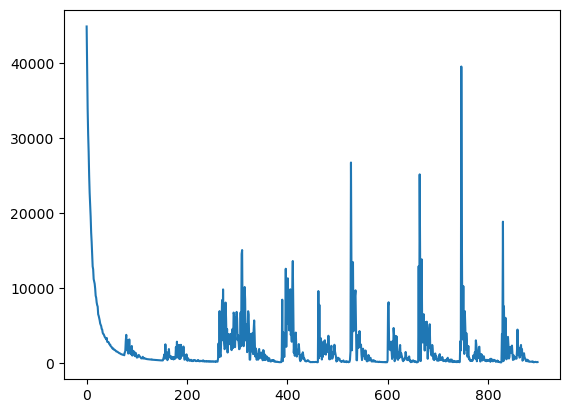

In [13]:
plt.plot(losses_train)

In [ ]:
plt.plot(losses_val)

In [ ]:
plt.plot(EVs)

In [ ]:
plt.plot(EVs)

In [ ]:
I = best_x.cpu().detach().numpy()
for i in range(5):
    fig,axes = plt.subplots(nrows = 1 , ncols = 5,  figsize=(20,4))
    for j in range (5):
        axes[j].imshow(I[5*i+j][0],interpolation='gaussian',cmap='gray')
        axes[j].tick_params(labelbottom=False,labelleft=False,left=False,bottom=False)
    fig.suptitle(f"5 generated images for one hot maximization of neural site {n_id[i]}")

show the results

# Problem (b)

# b - Neural site response stretch

In [ ]:
# CHOOSE THE AUGMENTS IF NECESSARY
n_id = np.random.randint(0, n_neurons, [5])  #inspect several neurons
rep_num = 5  # reptitions of each neuron
iters = 200 # iterations for synthesis
lr = 5e-3 # learing rate for synthesis
jitter = True # jitter the input for imitating the movement of the eyes

n_id_torch = torch.tensor(n_id.tolist(), dtype=torch.int64).to(device).repeat_interleave(rep_num).view(-1, 1)

def loss_TV(x):
    wd = x[:, :, 1:, :] - x[:, :, :-1, :]
    hd = x[:, :, :, 1:] - x[:, :, :, :-1]
    loss = (wd ** 2).mean([2]).sum() + (hd ** 2).mean([3]).sum()
    return loss

def jitter_image(img, max_pixels=19):
    sx, sy = np.random.randint(-max_pixels, max_pixels, size=2).tolist()
    img_shift = img.roll(sx, 3).roll(sy, 2)
    return img_shift

encoder.eval()
for param in encoder.parameters():
#     param.requires_grad_(False)
    param = param.detach()

init_images = np.random.uniform(0, 1, [len(n_id_torch), 1, 299, 299]).astype(np.float32)
x = torch.from_numpy(init_images)
x = x.to(device)


# PUT YOUR CODES HERE
"""
    In each iteration, you can use jitter_image() function to jitter the input
    image, and use transform predefined to apply standard imagnet preprocess

    Example:
        >>> x_jittered = jitter_image(x)
        >>> x_jittered = transform(x_jitter.repeat([1, 3, 1, 1]))
        ...

    In addition, it is better to normalize when updating the input image x

    Example:
        >>> grad = x.grad.detach()
        >>> grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
        >>> x = (x - lr * grad).clamp(0, 1).detach()
"""

In [ ]:
init_images = np.random.uniform(0, 1, [len(n_id_torch), 1, 299, 299]).astype(np.float32)
x = torch.from_numpy(init_images)
x = x.to(device)

In [ ]:
losses_tv = []
losses_res = []
losses = []
best_l_res = 0
best_x = None

In [ ]:
lr = 1e-1
lamb_tv = 1e-1
for i in tqdm_notebook(range(iters)):
    x = Variable(x,requires_grad = True)

    x_jittered = jitter_image(x,1)

    x_jittered = transform(x_jittered.repeat([1, 3, 1, 1]))

    fmap = alexnet(x_jittered,layer = insp_layer)

    out = encoder(fmap)
    l_res = -torch.sum(out.gather(dim=1,index=n_id_torch))
    l_tv = loss_TV(x)
    loss = l_res + lamb_tv * l_tv

    losses_tv.append(l_tv.item())
    losses_res.append(l_res.item())
    losses.append(loss.item())

    print(f'iteration {i}, L_tv = {losses_tv[-1]} , L_res = {losses_res[-1]} , total_loss = {losses[-1]}')
    if l_res < best_l_res:
        best_x = torch.tensor(x)
        best_l_res = l_res

    loss.backward()
    grad = x.grad.detach()

    grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
    x = (x - lr * grad).clamp(0, 1).detach()


In [ ]:
plt.plot(losses_tv)
plt.title("TV Loss")

In [ ]:
plt.plot(-np.array(losses_res))
plt.title("Target neural site response")

In [ ]:
plt.plot(losses)
plt.title("total loss")

## Result images

# c - One Hot Neural Site Response Maximization

In [ ]:
losses_tv_oh = []
losses_res_oh = []
losses_oh = []
best_l_oh = 0
best_x_oh = None

In [ ]:
init_images = np.random.uniform(0, 1, [len(n_id_torch), 1, 299, 299]).astype(np.float32)
x = torch.from_numpy(init_images)
x = x.to(device)

In [ ]:
lr = 1e-1
lamb_tv = 1e-3
    
# PUT YOUR CODES HERE
""" 
    In each iteration, you can use jitter_image() function to jitter the input 
    image, and use transform predefined to apply standard imagnet preprocess
    
    Example:
        >>> x_jittered = jitter_image(x)
        >>> x_jittered = transform(x_jitter.repeat([1, 3, 1, 1]))
        ...
    
    In addition, it is better to normalize when updating the input image x
    
    Example:
        >>> grad = x.grad.detach()
        >>> grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
        >>> x = (x - lr * grad).clamp(0, 1).detach()    
"""
for i in tqdm_notebook(range(iters)):
    x = Variable(x,requires_grad = True)

    x_jittered = jitter_image(x,max_pixels=5)
    x_jittered = transform(x_jittered.repeat([1, 3, 1, 1]))
    fmap = alexnet(x_jittered,layer = insp_layer)
    out = encoder(fmap)
    out = F.softmax(out)
    out = out.gather(dim=1,index=n_id_torch)
    l_res = -torch.sum(out)
    l_tv = loss_TV(x)
    loss = l_res + lamb_tv * l_tv
    
    losses_tv_oh.append(l_tv.item())
    losses_res_oh.append(l_res.item())
    losses_oh.append(loss.item())
    print(f'iteration {i}, L_tv = {losses_tv_oh[-1]} , L_res = {losses_res_oh[-1]} , total_loss = {losses_oh[-1]}')

    loss.backward()
    
    if l_res < best_l_oh:
        best_x_oh = torch.tensor(x)
        best_l_oh = l_res
    grad = x.grad.detach()
    grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
    x = (x - lr * grad).clamp(0, 1).detach()


In [ ]:
plt.plot(losses_tv_oh)
plt.title("TV Loss")

In [ ]:
plt.plot(-np.array(losses_res_oh))
plt.title("One hot response")

In [ ]:
plt.plot(losses_oh)
plt.title('total loss')

## Result images

In [ ]:
# x = x.cpu().detach().numpy()
I_oh = best_x_oh.cpu().detach().numpy()
for i in range(5):
    fig,axes = plt.subplots(nrows = 1 , ncols = 5,  figsize=(20,4))
    for j in range (5):
        axes[j].imshow(I_oh[5*i+j][0],interpolation='gaussian',cmap='gray')
        axes[j].tick_params(labelbottom=False,labelleft=False,left=False,bottom=False)
    fig.suptitle(f"5 generated images for one hot maximization of neural site {n_id[i]}")


## Comment

Neural sites have diffrent spatial receptive fields due to the spatial masks W_s. One hot response maximization of a target neural site should lead for the apparition of a localized pattern in the image space.

However most masks were localized at the same spots, on the edges of the feature map

In [ ]:
plt.imshow(encoder.W_s.detach().cpu().numpy()[17],cmap='gray')

In [ ]:
plt.imshow(encoder.W_s.detach().cpu().numpy()[26],cmap='gray')

In [ ]:
plt.imshow(encoder.W_s.detach().cpu().numpy()[13],cmap='gray')

In [ ]:
plt.imshow(encoder.W_s.detach().cpu().numpy()[46],cmap='gray')

In [ ]:
plt.imshow(encoder.W_s.detach().cpu().numpy()[0],cmap='gray')